In [1]:
import sys
sys.path.append("../../")
from mfmodeling import NARGP, SingleGP
import pickle

# Uncomment below to use GPy implementation.
# Note that only RBF kernel is supported in the GPy implementation now.
"""
from mfmodeling.SingleGP_GPy import SingleGP
from mfmodeling import set_gpy_usage_in_nargp
set_gpy_usage_in_nargp(True)
"""

help(NARGP)

2024-10-25 12:22:07.105003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 12:22:07.184991: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 12:22:07.188631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/

Help on class NARGP in module mfmodeling.NARGP:

class NARGP(builtins.object)
 |  NARGP(*args, **kwargs)
 |  
 |  Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP).
 |  P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
 |  Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Parameters
 |      ----------
 |      data_list : list[nfidelity]
 |          List of multi-fidelity training data of y=f(x), where input x and output y are vectors.
 |      
 |          Structure of the list of data is as follow.
 |          data_list[ 0] = [data_input_lowest[nsample_lowest,ninput],   data_output_lowest[nsample_lowest,noutput_lowest]]
 |          data_list[ 1] = [data_input_1st[nsample_1st,ninput],         data_output_1st[nsample_1st,noutput_1st]]
 |          ...
 |          data_list[-1] = [data_input_highest[

### Preparation of data set

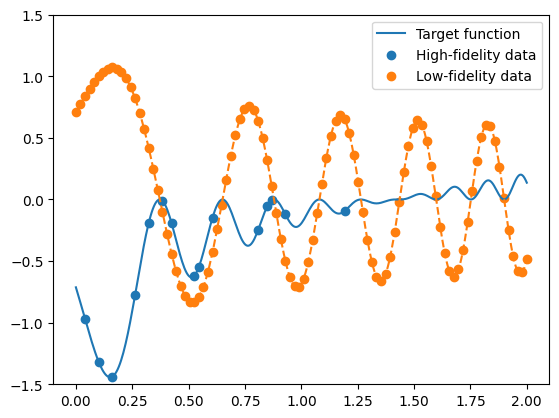

In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import scipy as sp

np.random.seed(24)
tf.random.set_seed(24)

''' function definitions '''
def high(x):
    return (x-np.sqrt(2))*low(x)**2
    # return low(x)**2

def low(x):
    # return np.sin(2.0*np.pi*x**2)
    Ai, Aip, Bi, Bip = sp.special.airy(-2*np.pi*x)
    return 2*Ai

''' Define training and test points '''
dim = 1
s = 2
plot = 1
N1 = 100
N2 = np.array([15])

Nts = 400
Xtest = np.linspace(0,2, Nts)[:,None]
Exact= high(Xtest)
Low = low(Xtest)

X1 = np.linspace(0,2, N1)[:,None]
# perm = np.random.permutation(N1)
perm = np.random.permutation(int(N1*0.6))
X2 = X1[perm[0:N2[0]]]

Y1 = low(X1)
Y2 = high(X2)

plt.plot(Xtest,Exact,label="Target function")
plt.plot(Xtest,Low,"--")
plt.scatter(X2,Y2,label="High-fidelity data")
plt.scatter(X1,Y1,label="Low-fidelity data")
plt.legend()
plt.ylim(-1.5,1.5)
plt.show()

In [3]:
# Set kernel name to use
KERNEL_NAME = "RBF"
# KERNEL_NAME = "SpectralMixture"
# KERNEL_NAME = "NeuralKernelNetwork"

data_list = [[X1,Y1], # Low-fidelity data set
             [X2,Y2]] # High-fidelity data set
single_gp_config_list = [
    {"kernel": KERNEL_NAME},
    {"kernel": KERNEL_NAME},
]

# Uncomment the following to use different kernel for different fidelity data.
# However, if GPy implementation are being used,
# Spectral Mixture Kernel and Neural Kernel Network are not implemented,
# so RBF will be used.
#single_gp_config_list = [
#    {"kernel": "RBF"},
#    {"kernel": "NeuralKernelNetwork"},
#]

model_nargp = NARGP(
    data_list = data_list,
    single_gp_config_list=single_gp_config_list,
    normalize=True)
model_nargp.optimize()

if KERNEL_NAME == "RBF":
    with open("model_NARGP_RBF.pkl","wb") as f:
        pickle.dump(model_nargp,f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_NARGP_SMK.pkl","wb") as f:
        pickle.dump(model_nargp,f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_NARGP_NKN.pkl","wb") as f:
        pickle.dump(model_nargp,f)


if KERNEL_NAME == "RBF":
    with open("model_NARGP_RBF.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_NARGP_SMK.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_NARGP_NKN.pkl","rb") as f:
        model_nargp = pickle.load(f)


import gpflow
for model in model_nargp.model_list:
    gpflow.utilities.print_summary(model)

mean, var = model_nargp.predict(Xtest)

NARGP is using GPflow.


2024-10-25 12:22:09.533734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.12/opt/mpi/libfabric/lib:/opt/intel/oneapi/mpi/2021.12/lib:/opt/intel/oneapi/mkl/2024.1/lib:/opt/intel/oneapi/ippcp/2021.11/lib/:/opt/intel/oneapi/ipp/2021.11/lib:/opt/intel/oneapi/dpl/2022.5/lib:/opt/intel/oneapi/dnnl/2024.1/lib:/opt/intel/oneapi/debugger/2024.1/opt/debugger/lib:/opt/intel/oneapi/dal/2024.2/lib:/opt/intel/oneapi/compiler/2024.1/opt/oclfpga/host/linux64/lib:/opt/intel/oneapi/compiler/2024.1/opt/compiler/lib:/opt/intel/oneapi/compiler/2024.1/lib:/opt/intel/oneapi/ccl/2021.12/lib/
2024-10-25 12:22:09.533773: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
202

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value        │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 10.10636     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.26522366] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1e-06        │
╘═════════════════════════╧═══════════╧═════════════════

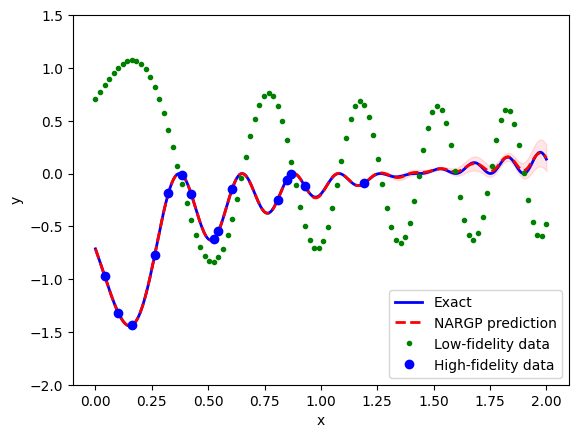

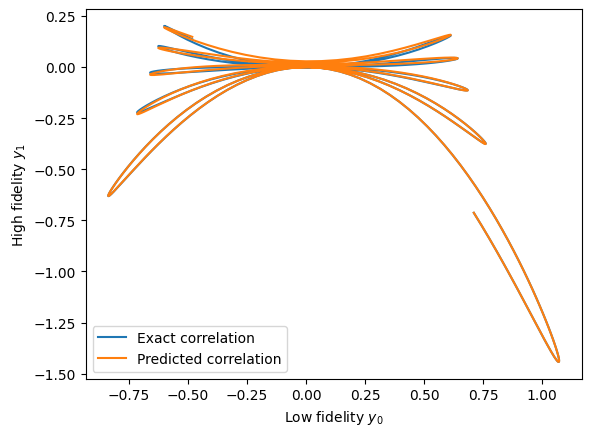

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Xtest, Exact, 'b', label='Exact', linewidth = 2)
ax.plot(Xtest, mean, 'r--', label = 'NARGP prediction', linewidth = 2)
ax.fill_between(Xtest.ravel(), (mean-2.0*np.sqrt(var)).ravel(), (mean+2.0*np.sqrt(var)).ravel(), alpha=0.1, color='red')
ax.plot(X1, Y1,'g.', label="Low-fidelity data")
ax.plot(X2, Y2,'bo', label="High-fidelity data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(-2,1.5)
ax.legend()
plt.show()

mean0, var0 = model_nargp.predict(Xtest,ifidelity=0)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Low, Exact, label = "Exact correlation")
ax.plot(mean0, mean, label = "Predicted correlation")
ax.set_xlabel(r"Low fidelity $y_0$")
ax.set_ylabel(r"High fidelity $y_1$")
ax.legend()
plt.show()

In [5]:
data = [X2,Y2] # Single GP using only high-fidelity data
model_singlegp = SingleGP(data = data)
model_singlegp = SingleGP(
    data = data,
    kernel = KERNEL_NAME,
    normalize=True)
model_singlegp.optimize()

if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","wb") as f:
        pickle.dump(model_singlegp,f)


if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","rb") as f:
        model_singlegp = pickle.load(f)


mean_singlegp, var_singlegp = model_singlegp.predict(Xtest)

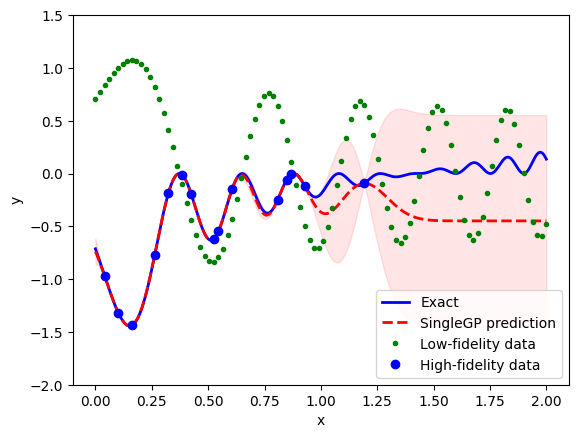

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Xtest, Exact, 'b', label='Exact', linewidth = 2)
ax.plot(Xtest, mean_singlegp, 'r--', label = 'SingleGP prediction', linewidth = 2)
ax.fill_between(Xtest.ravel(), (mean_singlegp-2.0*np.sqrt(var_singlegp)).ravel(), (mean_singlegp+2.0*np.sqrt(var_singlegp)).ravel(), alpha=0.1, color='red')
ax.plot(X1, Y1,'g.', label="Low-fidelity data")
ax.plot(X2, Y2,'bo', label="High-fidelity data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(-2,1.5)
ax.legend()
plt.show()